# Beaver Tutorial 4: GWAS Analysis (Data Scientist)

Run a **Genome-Wide Association Study (GWAS)** pipeline with step-by-step approval.

Each step returns results for review before proceeding:
1. **Merge** - Combine datasets
2. **PCA** - Population stratification
3. **Association** - Logistic regression
4. **Plots** - Manhattan & QQ plots

---

## Step 1: Setup

In [1]:
# import beaver
# beaver.dev()

In [2]:
!uv pip install pandas numpy matplotlib -q
print("Dependencies installed!")

Dependencies installed!


In [3]:
import beaver
from beaver import Twin
import time

bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")

🔄 Auto-load replies enabled for client2@sandbox.local (polling every 0.5s)
🟢 Active session loaded: d9efe11cc2d0
   Peer: client1@sandbox.local
  Deleted: .DS_Store
  Deleted: data/ (0 files)
  Deleted: inbox/ (2 files)
✓ Session reset: 3 files deleted
You: client2@sandbox.local
Peer: client1@sandbox.local


In [4]:
session.open()

## Step 2: Wait for GWAS Data

**Run DO notebook first!**

In [5]:
gwas_data = session.wait_for_remote_var("gwas_data", timeout=120)
if gwas_data:
    print(f"Mock info: {gwas_data.public['n_samples_1']} samples, {gwas_data.public['n_variants_1']} variants")
else:
    print("Timeout - run DO notebook first!")

⏳ Waiting for 'gwas_data' from client1@sandbox.local...
📬 'gwas_data' is now available!
✓ Loaded Twin 'gwas_data' from published location
Mock info: 30 samples, 100 variants


---
## GWAS Step 1: Merge Datasets

In [6]:
@bv
def gwas_step1_merge(data: dict) -> dict:
    """Merge two PLINK datasets."""
    import subprocess
    import tempfile
    from pathlib import Path
    
    print("="*50)
    print("STEP 1: MERGE DATASETS")
    print("="*50)
    
    DATASET1 = data['dataset1_prefix']
    DATASET2 = data['dataset2_prefix']
    WORKDIR = Path(tempfile.mkdtemp(prefix="gwas_"))
    COMBINED = WORKDIR / "combined"
    
    print(f"Dataset 1: {data['dataset1_name']}")
    print(f"Dataset 2: {data['dataset2_name']}")
    
    def run_plink(args):
        cmd = ["plink"] + args
        print(f">> {' '.join(cmd[:5])}...")
        proc = subprocess.run(cmd, capture_output=True, text=True)
        return proc.returncode
    
    # Try merge
    ret = run_plink(["--bfile", DATASET1, "--bmerge", DATASET2, "--out", str(COMBINED)])
    
    # Handle strand flips
    missnp = Path(f"{COMBINED}-merge.missnp")
    if ret != 0 and missnp.exists():
        print("Strand issues found, flipping...")
        flipped = f"{DATASET2}_flipped"
        run_plink(["--bfile", DATASET2, "--flip", str(missnp), "--make-bed", "--out", flipped])
        run_plink(["--bfile", DATASET1, "--bmerge", flipped, "--out", str(COMBINED)])
    
    # Count samples/variants
    fam_path = Path(f"{COMBINED}.fam")
    bim_path = Path(f"{COMBINED}.bim")
    
    n_samples = sum(1 for _ in open(fam_path))
    n_variants = sum(1 for _ in open(bim_path))
    
    # Count cases/controls
    cases, controls = 0, 0
    for line in open(fam_path):
        pheno = line.split()[5]
        if pheno == "2": cases += 1
        elif pheno == "1": controls += 1
    
    print(f"\nMerged: {n_samples} samples, {n_variants} variants")
    print(f"Cases: {cases}, Controls: {controls}")
    
    return {
        'status': 'merged',
        'combined_prefix': str(COMBINED),
        'workdir': str(WORKDIR),
        'n_samples': n_samples,
        'n_variants': n_variants,
        'cases': cases,
        'controls': controls,
    }

In [7]:
# Test on mock, then request real
merge_result = gwas_step1_merge(gwas_data)
print(f"\nMock result: {merge_result.public}")

merge_result.request_private()
print("\nMerge request sent! Run DO to approve...")


Mock result: {'status': 'merged', 'combined_prefix': '/var/folders/6_/7xx0tpq16h9cn40mq4w5gjk80000gn/T/gwas_4uxp_8wp/combined', 'workdir': '/var/folders/6_/7xx0tpq16h9cn40mq4w5gjk80000gn/T/gwas_4uxp_8wp', 'n_samples': 30, 'n_variants': 100, 'cases': 0, 'controls': 15}
📨 Sending computation request to client1@sandbox.local
   Function: gwas_step1_merge
   Result: merge_result
✓ Sent to /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/a9256d261cc04e1b8b63dd17cfbfe4ba.beaver
💡 Result will auto-update when client1@sandbox.local approves

Merge request sent! Run DO to approve...


In [8]:
# Wait for merge results
merge_approved = bv.wait_for_response(merge_result, timeout=300)

if merge_approved and merge_approved.private:
    r = merge_approved.private
    print(f"Merged: {r['n_samples']} samples, {r['n_variants']} variants")
    print(f"Cases: {r['cases']}, Controls: {r['controls']}")
    
    # Store for next step
    merged_data = r

⏳ Waiting for response to 'gwas_step1_merge_result'...
   Looking for reply_to: ee2a105b9575...
   Watching: ['/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault']
📬 Response received for 'gwas_step1_merge_result'
   From: client1@sandbox.local
✅ 'gwas_step1_merge_result' updated with result
Merged: 284 samples, 655839 variants
Cases: 67, Controls: 215


---
## GWAS Step 2: PCA for Population Stratification

In [9]:
@bv
def gwas_step2_pca(data: dict) -> dict:
    """Run PCA for population stratification."""
    import subprocess
    from pathlib import Path
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import pandas as pd
    
    print("="*50)
    print("STEP 2: PCA")
    print("="*50)
    
    COMBINED = data['combined_prefix']
    WORKDIR = Path(data['workdir'])
    N_PCS = 10
    
    def run_plink(args):
        cmd = ["plink"] + args
        print(f">> {' '.join(cmd[:5])}...")
        subprocess.run(cmd, capture_output=True)
    
    # LD pruning
    print("LD pruning...")
    run_plink(["--bfile", COMBINED, "--indep-pairwise", "50", "5", "0.2", "--out", f"{COMBINED}_pruned"])
    run_plink(["--bfile", COMBINED, "--extract", f"{COMBINED}_pruned.prune.in", "--make-bed", "--out", f"{COMBINED}_pruned_data"])
    
    # Remove ambiguous SNPs
    atgc = WORKDIR / "atgc.txt"
    with open(f"{COMBINED}_pruned_data.bim") as f, open(atgc, "w") as out:
        for line in f:
            fields = line.split()
            a1, a2 = fields[4], fields[5]
            if (a1, a2) in [("A","T"),("T","A"),("C","G"),("G","C")]:
                out.write(fields[1] + "\n")
    
    run_plink(["--bfile", f"{COMBINED}_pruned_data", "--exclude", str(atgc), "--make-bed", "--out", f"{COMBINED}_noambig"])
    
    # Run PCA
    print(f"Computing {N_PCS} PCs...")
    run_plink(["--bfile", f"{COMBINED}_noambig", "--pca", str(N_PCS), "--out", f"{COMBINED}_pca"])
    
    # Add header to eigenvec
    eigenvec = Path(f"{COMBINED}_pca.eigenvec")
    header = " ".join(["FID", "IID"] + [f"PC{i}" for i in range(1, N_PCS+1)]) + "\n"
    content = eigenvec.read_text()
    eigenvec.write_text(header + content)
    
    # Plot PCA
    print("Generating PCA plot...")
    df = pd.read_csv(eigenvec, sep=r"\s+")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['PC1'], df['PC2'], alpha=0.6, s=20)
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_title('Population Structure (PCA)', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("PCA complete!")
    
    return {
        'status': 'pca_complete',
        'combined_prefix': COMBINED,
        'workdir': str(WORKDIR),
        'eigenvec_path': str(eigenvec),
        'n_pcs': N_PCS,
        'n_samples': len(df),
    }


Mock PCA complete
📊 Public figures (1):


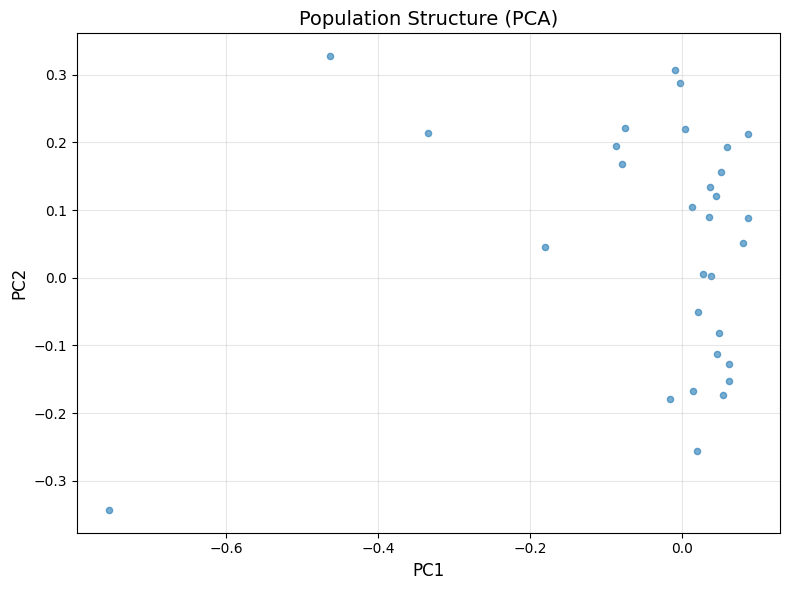

📨 Sending computation request to client2@sandbox.local
   Function: gwas_step2_pca
   Result: pca_result
✓ Sent to /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/8f279a3c03174988a0a5d9c051fdfbd3.beaver
💡 Result will auto-update when client2@sandbox.local approves

PCA request sent! Run DO to approve...


In [10]:
# Create Twin from merge results for PCA step
pca_input = Twin(
    public=merge_result.public,  # Mock merge result
    private=merged_data,          # Real merge result from DO
    name="pca_input"
)

pca_result = gwas_step2_pca(pca_input)
print(f"\nMock PCA complete")
pca_result.show_figures("public")

pca_result.request_private()
print("\nPCA request sent! Run DO to approve...")

In [ ]:
# Wait for PCA results
pca_approved = bv.wait_for_response(pca_result, timeout=300)

if pca_approved and pca_approved.private:
    r = pca_approved.private
    print(f"PCA complete: {r['n_pcs']} PCs computed for {r['n_samples']} samples")
    pca_approved.show_figures("private")
    pca_data = r

⏳ Waiting for response to 'gwas_step2_pca_result'...
   Looking for reply_to: aff7d521be58...
   Watching: ['/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault']


---
## GWAS Step 3: Association Testing

In [ ]:
@bv
def gwas_step3_association(data: dict) -> dict:
    """Run logistic regression with PCA covariates."""
    import subprocess
    from pathlib import Path
    import pandas as pd
    import numpy as np
    
    print("="*50)
    print("STEP 3: ASSOCIATION TESTING")
    print("="*50)
    
    COMBINED = data['combined_prefix']
    eigenvec = data['eigenvec_path']
    N_PCS = data['n_pcs']
    
    covar_names = ",".join([f"PC{i}" for i in range(1, N_PCS+1)])
    
    print("Running logistic regression...")
    cmd = ["plink", "--bfile", COMBINED, "--logistic", "hide-covar",
           "--covar", eigenvec, "--covar-name", covar_names,
           "--ci", "0.95", "--out", f"{COMBINED}_gwas"]
    print(f">> {' '.join(cmd[:6])}...")
    subprocess.run(cmd, capture_output=True)
    
    # Load results
    results_file = f"{COMBINED}_gwas.assoc.logistic"
    df = pd.read_csv(results_file, sep=r"\s+")
    df = df[df['P'].notna()]
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna(subset=['P'])
    df = df[(df['P'] > 0) & (df['P'] <= 1)]
    
    # Count significant
    gw_sig = len(df[df['P'] < 5e-8])
    suggestive = len(df[df['P'] < 1e-5])
    
    # Genomic inflation
    chisq = -2 * np.log(df['P'])
    lambda_gc = np.median(chisq) / 0.456
    
    print(f"\nTested: {len(df)} SNPs")
    print(f"Genome-wide significant (P < 5e-8): {gw_sig}")
    print(f"Suggestive (P < 1e-5): {suggestive}")
    print(f"Genomic inflation λ: {lambda_gc:.3f}")
    
    # Top SNPs
    top_snps = []
    for _, row in df.nsmallest(20, 'P').iterrows():
        top_snps.append({
            'snp': row['SNP'],
            'chr': int(row['CHR']) if pd.notna(row['CHR']) else 0,
            'bp': int(row['BP']) if pd.notna(row['BP']) else 0,
            'p': float(row['P']),
            'or': float(row['OR']) if 'OR' in row and pd.notna(row['OR']) else None,
        })
    
    return {
        'status': 'association_complete',
        'combined_prefix': COMBINED,
        'results_file': results_file,
        'tested_snps': len(df),
        'gw_significant': gw_sig,
        'suggestive': suggestive,
        'lambda_gc': float(lambda_gc),
        'top_snps': top_snps,
    }

In [ ]:
# Create Twin from PCA results
assoc_input = Twin(
    public=pca_result.public,
    private=pca_data,
    name="assoc_input"
)

assoc_result = gwas_step3_association(assoc_input)
print(f"\nMock association: {assoc_result.public.get('tested_snps', 0)} SNPs tested")

assoc_result.request_private()
print("\nAssociation request sent! Run DO to approve...")

In [ ]:
# Wait for association results
assoc_approved = bv.wait_for_response(assoc_result, timeout=600)

if assoc_approved and assoc_approved.private:
    r = assoc_approved.private
    print(f"Association complete!")
    print(f"  Tested: {r['tested_snps']} SNPs")
    print(f"  GW significant: {r['gw_significant']}")
    print(f"  Suggestive: {r['suggestive']}")
    print(f"  Lambda: {r['lambda_gc']:.3f}")
    
    if r['top_snps']:
        print(f"\nTop SNPs:")
        for snp in r['top_snps'][:5]:
            print(f"  {snp['snp']}: P={snp['p']:.2e}")
    
    assoc_data = r

---
## GWAS Step 4: Generate Plots

In [ ]:
@bv
def gwas_step4_plots(data: dict) -> dict:
    """Generate Manhattan and QQ plots."""
    from pathlib import Path
    import pandas as pd
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
    print("="*50)
    print("STEP 4: GENERATE PLOTS")
    print("="*50)
    
    results_file = data['results_file']
    
    # Load results
    df = pd.read_csv(results_file, sep=r"\s+")
    df = df[df['P'].notna()]
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna(subset=['P'])
    df = df[(df['P'] > 0) & (df['P'] <= 1)]
    df['NEGLOG10P'] = -np.log10(df['P'])
    df = df[np.isfinite(df['NEGLOG10P'])]
    
    # Clean chromosomes
    df['CHR'] = df['CHR'].replace({'X': 23, 'Y': 24, 'MT': 25})
    df['CHR'] = pd.to_numeric(df['CHR'], errors='coerce')
    df = df.dropna(subset=['CHR', 'BP'])
    df['CHR'] = df['CHR'].astype(int)
    df['BP'] = df['BP'].astype(int)
    df = df.sort_values(['CHR', 'BP']).reset_index(drop=True)
    
    print(f"Plotting {len(df)} SNPs...")
    
    # --- Manhattan Plot ---
    print("Creating Manhattan plot...")
    
    df['cumpos'] = 0
    chr_centers = []
    last_pos = 0
    for chrom in sorted(df['CHR'].unique()):
        chr_df = df[df['CHR'] == chrom]
        chr_len = chr_df['BP'].max()
        df.loc[df['CHR'] == chrom, 'cumpos'] = chr_df['BP'] + last_pos
        chr_centers.append(last_pos + chr_len / 2)
        last_pos += chr_len
    
    fig, ax = plt.subplots(figsize=(14, 5))
    colors = ['#3182bd', '#9ecae1']
    chr_list = sorted(df['CHR'].unique())
    
    for idx, chrom in enumerate(chr_list):
        chr_df = df[df['CHR'] == chrom]
        ax.scatter(chr_df['cumpos'], chr_df['NEGLOG10P'],
                  c=colors[idx % 2], s=3, alpha=0.6)
    
    ax.axhline(y=-np.log10(5e-8), color='red', linestyle='--', lw=1.5, label='GW sig (5e-8)')
    ax.axhline(y=-np.log10(1e-5), color='blue', linestyle='--', lw=1, label='Suggestive (1e-5)')
    
    # Annotate top hits
    top = df[df['P'] < 1e-5].nsmallest(10, 'P')
    for _, snp in top.iterrows():
        ax.annotate(snp['SNP'], (snp['cumpos'], snp['NEGLOG10P']),
                   fontsize=7, alpha=0.8, xytext=(3, 3), textcoords='offset points')
        ax.scatter([snp['cumpos']], [snp['NEGLOG10P']], c='red', s=25, marker='D', zorder=5)
    
    ax.set_xticks(chr_centers)
    ax.set_xticklabels([str(c) for c in chr_list])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log₁₀(P)')
    ax.set_title('Manhattan Plot')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    # --- QQ Plot ---
    print("Creating QQ plot...")
    
    pvals = df['P'].dropna()
    pvals = pvals[pvals > 0]
    observed = -np.log10(sorted(pvals))
    n = len(observed)
    expected = -np.log10(np.arange(1, n + 1) / (n + 1))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(expected, observed, s=8, alpha=0.5, c='#3182bd')
    max_val = max(max(expected), max(observed))
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Expected')
    
    lambda_gc = data.get('lambda_gc', 0)
    ax.text(0.05, 0.95, f'λ = {lambda_gc:.3f}', transform=ax.transAxes,
           fontsize=11, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Expected -log₁₀(P)')
    ax.set_ylabel('Observed -log₁₀(P)')
    ax.set_title('QQ Plot')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    print("Plots complete!")
    
    return {
        'status': 'plots_complete',
        'n_snps_plotted': len(df),
    }

In [ ]:
# Create Twin from association results
plots_input = Twin(
    public=assoc_result.public,
    private=assoc_data,
    name="plots_input"
)

plots_result = gwas_step4_plots(plots_input)
print(f"\nMock plots:")
plots_result.show_figures("public")

plots_result.request_private()
print("\nPlots request sent! Run DO to approve...")

In [ ]:
# Wait for plots
plots_approved = bv.wait_for_response(plots_result, timeout=300)

if plots_approved:
    print("GWAS plots received!")
    print(f"\n=== Manhattan & QQ Plots from REAL Data ===")
    plots_approved.show_figures("private")

---
## Summary

You ran a complete GWAS in 4 steps:

1. **Merge** - Combined datasets, got sample/variant counts
2. **PCA** - Population stratification, saw PCA plot
3. **Association** - Logistic regression, got top SNPs
4. **Plots** - Manhattan & QQ plots

### Privacy Preserved!

- You received **summary statistics** and **plots**
- You did NOT receive raw genotype data
- DO approved each step before proceeding